In [12]:
import numpy as np
import scipy as sp

import numpy.linalg as la
import scipy.linalg as sla
import scipy.sparse.linalg as ssla

from matplotlib import pyplot as plt

from CircuitDiagonalization import *

# Single cavity - Constant boundary conditions

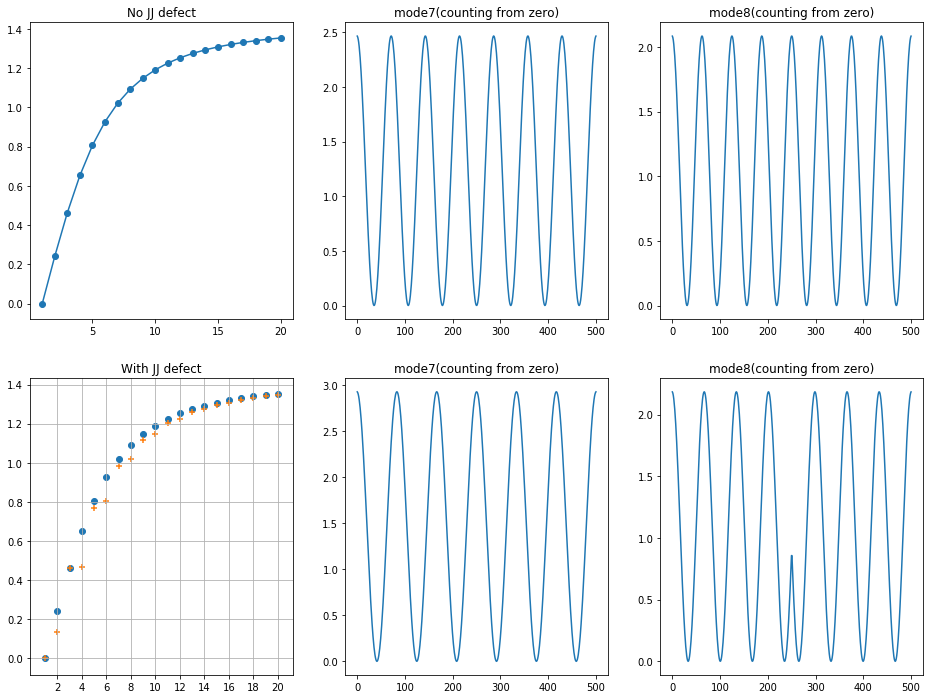

In [20]:
# System parameters
# Grid size (number of LC units in JJA resonator) 
Nx = 500 # Like L
# Circuit parameters
Ljja, Cjja, Cjjagnd = 0.66E-9, 144E-15, 1.89E-16

#************** NO JJ DEFECT *******************************
Ljjdefect, Cjjdefect = Ljja, Cjja # no defect case
# Number of eigenvalues to compute
nEig = 20
kRefVec = np.ones( (nEig,) )
# Compute reference eigenvalues (closed cavity case, Neumann boundary conditions)
refVals, refVecs, C1D, L1D = JJAEigs(Nx, Cjjagnd, Ljja, Cjja, Ljjdefect, Cjjdefect, nEig, bc="neu", disp="on")

# Plot frequencies
#noJJDefectEigs = np.sqrt(np.real(refVals))
noJJDefectEigs = np.real(np.abs(refVals))
fig, axs = plt.subplots(2, 3, figsize=(16,12))
axs[0, 0].scatter(np.arange(1,nEig+1,1),np.sqrt(noJJDefectEigs))
axs[0, 0].plot(np.arange(1,nEig+1,1),np.sqrt(noJJDefectEigs))
axs[0, 0].set_title('No JJ defect')

# Plot any two successive eigenmodes
x = np.linspace(0,Nx,Nx)
mN = 7
axs[0, 1].plot(x, np.abs(refVecs[:,mN])**2)
axs[0, 1].set_title('mode' + str(mN) + '(counting from zero)')

mN = 8
axs[0, 2].plot(x, np.abs(refVecs[:,mN])**2)
axs[0, 2].set_title('mode' + str(mN) + '(counting from zero)')

#**************************************************************

#*************************** IN PROGRESS, IGNORE FOR NOW ******************************
# Constructing even/odd combinations of left and right JJA modes
#oddMode = 0.5*np.add( refVecs[0:500,mN],-np.flipud(refVecs[500:,mN]) )
#evenMode = 0.5*np.add( refVecs[0:500,mN],np.flipud(refVecs[500:,mN]) )
#xhalf = np.linspace(0,Nx/2,Nx/2)
#axs[0, 1].plot(xhalf, np.abs(oddMode**2))
#axs[0, 1].plot(xhalf, np.abs(evenMode)**2)
#**********************************************************************

#**************** WITH JJ DEFECT **************************************
Ljja, Cjja, Cjjagnd = 0.66E-9, 144E-15, 1.89E-16
Ljjdefect, Cjjdefect =  285.0E-9, 3.0E-15 # with JJ defect

kRefVec = np.ones( (nEig,) )
# Compute reference eigenvalues (closed cavity case, Neumann boundary conditions)
refVals, refVecs, C1D, L1D = JJAEigs(Nx, Cjjagnd, Ljja, Cjja, Ljjdefect, Cjjdefect, nEig, bc="neu", disp="on")
#withJJDefectEigs = np.sqrt(np.real(refVals))
withJJDefectEigs = np.real(np.abs(refVals))
axs[1, 0].scatter(np.arange(1,nEig+1,1),np.sqrt(noJJDefectEigs), marker='o')
axs[1, 0].scatter(np.arange(1,nEig+1,1),np.sqrt(withJJDefectEigs), marker='+')
#axs[1, 0].plot(np.arange(1,nEig+1,1),np.real(refVals))
axs[1, 0].set_title('With JJ defect')
axs[1, 0].set_xticks(np.arange(2,nEig+1,2))
axs[1, 0].grid(True)

# Plot the two successive mode numbers of noJJDefect case above to see 
#which one is affected by the presence of the JJ defect
x = np.linspace(0,Nx,Nx)
mN = 7
axs[1, 1].plot(x, np.abs(refVecs[:,mN])**2)
axs[1, 1].set_title('mode' + str(mN) + '(counting from zero)')
mN = 8
axs[1, 2].plot(x, np.abs(refVecs[:,mN])**2)
axs[1, 2].set_title('mode' + str(mN) + '(counting from zero)')

plt.show()

# The following plots the images of the inductance and capacitance matrices
#fig, ax = plt.subplots(1, 1, figsize=(8,8))
#C1Dr = np.real(C1D)
#plt.imshow(C1Dr.toarray(), interpolation='nearest')
#plt.show()
#fig, ax = plt.subplots(1, 1, figsize=(8,8))
#L1Dr = np.real(L1D)
#plt.imshow(L1Dr.toarray(), interpolation='nearest')
#plt.show()

# Single cavity - Iterative eigenvalue problem for outgoing boundary conditions

In [21]:
errTol = 1e-5
itNum = 20
# Circuit parameters
Ljja, Cjja, Cjjagnd = 0.66E-9, 144E-15, 1.89E-16
#Ljjdefect, Cjjdefect = Ljja, Cjja
Ljjdefect, Cjjdefect =  285.0E-9, 3.0E-15
Lleft, Cleft, Cin = 5.0*Ljja, 100.0*Cjja, 10.0*Cjja
#Lleft, Cleft, Cin = 273.0E-9, 93.5E-12, 100.0*Cjja
Lright, Cright, Cout = Lleft, Cleft, Cin
# Number of eigenvalues to compute
nEig = 20
kRefVec = np.ones( (nEig,) )
# Compute reference eigenvalues (closed cavity case, Neumann boundary conditions)
refVals, refVecs, C1D, L1D = JJAEigs(Nx, Cjjagnd, Ljja, Cjja, Ljjdefect, Cjjdefect, nEig, bc="neu", disp="on")
# Use the JJA with defect eigenvalues as initial guess for the iteration
kRef = np.real(refVals) # Note that these are scaled Omega squared values!

nCom = len(kRef)

# Solve eigenvalue problem
kVals, spEigVecs, errVals = JJAResOpenEigs(Nx, Lleft, Cleft, Cin, Cjjagnd, Ljja, Cjja, Ljjdefect, Cjjdefect, Lright, Cright, Cout, kRef, errTol=1e-5, itNum=20, disp="on")

Mode: 8, err: 0.056516787235776356, iteration:  0
EigVal (1.1944670800700272-1.88581644627077e-08j)
Mode: 8, err: 7.78318920424681e-09, iteration:  1
EigVal (1.1944670878532164-2.0212217823768644e-08j)
Mode: 9, err: 0.0456498751972132, iteration:  0
EigVal (1.3626681801341949-1.0537192764330995e-08j)
Mode: 9, err: 3.1631239849616577e-09, iteration:  1
EigVal (1.362668176971071-1.0012177135762385e-08j)
Mode: 10, err: 0.03107403003608411, iteration:  0
EigVal (1.420613304148781-7.812839509180888e-09j)
Mode: 10, err: 1.6090155874337597e-09, iteration:  1
EigVal (1.4206133057577965-8.070568411334576e-09j)
Mode: 11, err: 0.026430674894732942, iteration:  0
EigVal (1.5282753849188884-4.800037685950597e-09j)
Mode: 11, err: 7.95441268408581e-10, iteration:  1
EigVal (1.528275384123447-4.676061134015787e-09j)
Mode: 12, err: 0.01768664555715227, iteration:  0
EigVal (1.5712516714883573-3.7408653311643285e-09j)
Mode: 12, err: 4.152169719162657e-10, iteration:  1
EigVal (1.5712516719035743-3.80420

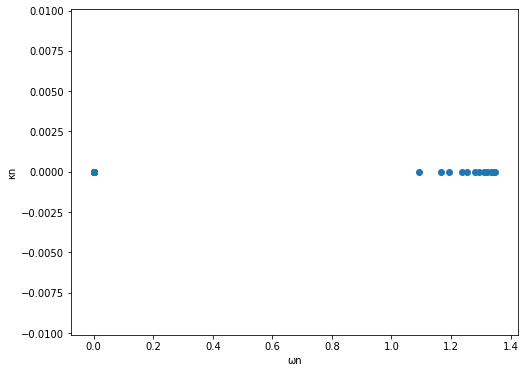

In [22]:
# Plot real and imaginary parts
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.scatter(np.real(np.sqrt(kVals)), -np.imag(np.sqrt(kVals)) )
# ax.set_xticks(np.arange(2,nCom+1,2))
#ax.set_ylim([-0.0001, -1.1*np.min(np.imag(np.sqrt(kVals)))])
ax.set_ylabel('κn')
ax.set_xlabel('ωn')
plt.show()

In [ ]:
# Plot eigenvectors
x = np.linspace(-1,Nx-1,Nx)
mN = 10 # Mode number to plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(x, np.abs(spEigVecs[:,mN])**2 )
ax.set_title('Eigenvalue: ' + str(kVals[mN]))
plt.show()

## Iterative solver

In [ ]:
# System parameters
# Grid size (number of LC units in JJA resonator) 
Nx = 1000 # Like L
# Nx = 1500 # Like L
# Circuit parameters
L, C, Cg = 1.0, 1*100.0, 1.0
# Number of eigenvalues to compute
nEig = 30
# Waveguide parameters
l, c = 1.0, 1.0
# Outcoupling parameters
CL, CR = 1.0, 1.0
# CL, CR = 10.0, 10.0
# CL, CR = 100.0, 100.0

eigVals, eigVecs = JJAResOpenIterEigs(Nx, L, C, Cg, l, c, CL, CR, nEig=nEig, errTol=1e-5, itNum=5, capItNum=10, disp="on")

In [ ]:
# Plot real and imaginary parts
fig, axs = plt.subplots(1, 2, figsize=(16,6))
ax = axs[0]
ax.scatter(np.real(eigVals)*Nx/np.pi, -np.imag(eigVals)*Nx/np.pi )
# ax.set_xticks(np.arange(2,nCom+1,2))
ax.set_ylim([-0.000001*Nx/np.pi, -1.1*np.min(np.imag(eigVals))*Nx/np.pi])
ax.set_xlabel('ωn/π')
ax.set_ylabel('κn/π')

ax = axs[1]
ax.scatter(np.arange(1,nEig,1), np.real(eigVals)*Nx/np.pi )
ax.plot(np.arange(1,nEig,1), np.real(eigVals)*Nx/np.pi )
ax.set_xlabel('n')
ax.set_ylabel('ωn/π')
plt.show()

# Coupled JJA resonators

In [ ]:
# System parameters
# Grid size (number of LC units in JJA resonator) 
Nx = 1000 # Like L
# Circuit parameters
L, C, Cg = 1.0, 1*100.0, 1.0
# Junction parameters
LJ, Csh = 1.0, 1*90.0
# Number of eigenvalues to compute
nEig = 30

# Compute reference eigenvalues (closed cavity case, Neumann boundary conditions)
refVals, refVecs = JJACoupledResClosedEigs(Nx, L, C, Cg, LJ, Csh, nEig=nEig, bc="neu")

In [ ]:
# Plot frequencies
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.scatter(np.arange(1,nEig+1,1), np.real(refVals) )
ax.plot(np.arange(1,nEig+1,1), np.real(refVals) )
ax.set_xticks(np.arange(2,nEig+1,2))
plt.show()

# Plot eigenvectors
x = np.linspace(0,Nx,Nx)
mN = 5 # Mode number to plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(x, np.abs(refVecs[:,mN])**2 )
plt.show()

# Testing, C = 0 case

In [ ]:
# System parameters
# Grid size (number of LC units in JJA resonator) 
Nx = 1000 # Like L
# Circuit parameters
L, C, Cg = 1.0, 0*100.0, 1.0
# Number of eigenvalues to compute
nEig = 30

# Compute reference eigenvalues (closed cavity case, Neumann boundary conditions)
refVals, refVecs = JJAResClosedEigs(Nx, L, C, Cg, nEig=nEig, bc="neu")

# Plot eigenvectors
x = np.linspace(0,Nx,Nx)
mN = 2 # Mode number to plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(x, np.abs(refVecs[:,mN])**2 )
plt.show()

In [ ]:
# System parameters
# Waveguide parameters
l, c = 1.0, 1.0
# Outcoupling parameters
CL, CR = 1.0, 1.0
# Reference eigenvalue
# kRef = [0.04]
# kRef = np.real((refVals[1:10]))
kRef = np.real(refVals[1:-1])
nCom = len(kRef)

# Solve eigenvalue problem
kVals, spEigVecs, errVals = JJAResOpenEigs(Nx, L, C, Cg, l, c, CL, CR, kRef, errTol=1e-5, itNum=5, disp="off")

# Quality factor
QVec = np.imag(kVals)/np.real(kVals)

In [ ]:
# Plot real and imaginary parts
fig, axs = plt.subplots(1, 2, figsize=(16,6))
ax = axs[0]
ax.scatter(np.real(kVals)*Nx/np.pi, -np.imag(kVals)*Nx/np.pi )
# ax.set_xticks(np.arange(2,nCom+1,2))
ax.set_ylim([-0.000001*Nx/np.pi, -1.1*np.min(np.imag(kVals))*Nx/np.pi])
ax.set_xlabel('ωn/π')
ax.set_ylabel('κn/π')

ax = axs[1]
ax.scatter(np.arange(1,nCom+1,1), np.real(kVals)*Nx/np.pi )
ax.plot(np.arange(1,nCom+1,1), np.real(kVals)*Nx/np.pi )
ax.set_xlabel('n')
ax.set_ylabel('ωn/π')
plt.show()

In [ ]:
# System parameters
# Grid size (number of LC units in JJA resonator) 
Nx = 1000 # Like L
# Circuit parameters
L, C, Cg = 1, 0*100.0, 1.0
# Number of eigenvalues to compute
nEig = 30
# Waveguide parameters
l, c = 1.0, 1.0
# Outcoupling parameters
# CL, CR = 1.0, 1.0
CL, CR = 10.0, 10.0
# CL, CR = 100.0, 100.0

eigVals, eigVecs = JJAResOpenIterEigs(Nx, L, C, Cg, l, c, CL, CR, nEig=nEig, errTol=1e-5, itNum=5, capItNum=10, disp="off")

In [ ]:
# Plot real and imaginary parts
fig, axs = plt.subplots(1, 2, figsize=(16,6))
ax = axs[0]
ax.scatter(np.real(eigVals)*Nx/np.pi, -np.imag(eigVals)*Nx/np.pi )
# ax.set_xticks(np.arange(2,nCom+1,2))
ax.set_ylim([-0.000001*Nx/np.pi, -1.1*np.min(np.imag(eigVals))*Nx/np.pi])
ax.set_xlabel('ωn/π')
ax.set_ylabel('κn/π')

ax = axs[1]
ax.scatter(np.arange(1,nEig,1), np.real(eigVals)*Nx/np.pi )
ax.plot(np.arange(1,nEig,1), np.real(eigVals)*Nx/np.pi )
ax.set_xlabel('n')
ax.set_ylabel('ωn/π')
plt.show()

In [ ]:
# Plot eigenvectors
x = np.linspace(0,Nx,Nx)
mN = 5 # Mode number to plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(x, np.abs(eigVecs[:,mN])**2 )
plt.show()

## Mode amplitudes at JJ positions

In [ ]:
# Vector to store amplitudes
ampVec = np.zeros( (nEig-1,), dtype=complex)
# Position at which to calculate amplitude
# pos = 500
pos = 125
# pos = 1
for n in range(1,nEig):
    ampVec[n-1] = np.abs(refVecs[pos,n])
    
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.scatter(np.arange(1,nEig,1), ampVec)
ax.plot(np.arange(1,nEig,1), ampVec)
plt.show()